In [1]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = torch.mean(x, dim=0)
    my = torch.mean(y, dim=0)
    xm, ym = x - mx, y - my
    r_num = torch.sum(xm * ym,dim=0)
    x_square_sum = torch.sum(xm * xm,dim=0)
    y_square_sum = torch.sum(ym * ym,dim=0)
    r_den = torch.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return r#torch.mean(r)

## Load data 

In [162]:
L1 = torch.tensor(pd.read_csv('../results/L1.tsv',sep=' ').values).to(device)
L2 = torch.tensor(pd.read_csv('../results/L2.tsv',sep=' ').values).to(device)
Y_tilda = torch.tensor(pd.read_csv('../results/K.tsv',sep=' ').values).to(device)
A2 = torch.tensor(pd.read_csv('../results/A2.tsv',sep=' ').values).to(device)
Z1 = torch.tensor(pd.read_csv('../results/Z1.tsv',sep=' ').values).to(device)

## Define trainable wieght and loss function

In [163]:
class WeightMatrix(torch.nn.Module):
    def __init__(self, in_channel, out_channel, bias=False,dtype=torch.double):
        super(WeightMatrix, self).__init__()
        self.bias = False
        self.linear = torch.nn.Linear(in_channel, out_channel, bias=bias,dtype=dtype)
        self.init_weights()
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    def forward(self,x):
        y = self.linear(x)
        return y
    def L2Regularization(self, L2):

        weightLoss = L2 * torch.sum((self.linear.weight)**2)
        biasLoss = 0.
        if self.bias==True:
            biasLoss = biasLoss + L2 * torch.sum((self.linear.bias)**2)
        L2Loss = biasLoss + weightLoss
        return(L2Loss)

In [164]:
P = WeightMatrix(L1.shape[1],L2.shape[1])
P = P.to(device)
P.linear.weight.data = torch.matmul(L2.T,L1) + P.linear.weight.data

In [165]:
optimizer = torch.optim.Adam(P.parameters(), lr= 0.01, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.8)
I = torch.eye(P.linear.weight.shape[0]).to(device)
LI = 10.

In [166]:
NUM_EPOCHS = 10000

In [167]:
all_loses =  np.zeros(NUM_EPOCHS)
for e in range(NUM_EPOCHS):
    P.train()
    optimizer.zero_grad()
    L2_hat = P(L1)
    L1_hat = torch.matmul(L2,P.linear.weight)
    #M = torch.matmul(P.linear.weight,P.linear.weight.T)
    #Yhat_tilda = torch.matmul(torch.matmul(X,L2_hat),A2)
    Yhat_tilda = torch.matmul(torch.matmul(Z1,P.linear.weight.T),A2)
    loss = torch.sum(torch.square(Y_tilda - Yhat_tilda)) 
    loss = loss + torch.sum(torch.sum(torch.square(L2 - L2_hat),0)) + torch.sum(torch.sum(torch.square(L1 - L1_hat),0))
    #regularization = LI*torch.sum(torch.abs(M - I)) # + P.L2Regularization(1e-06)
    #loss = loss + regularization
    loss.backward()
    optimizer.step()
    scheduler.step()
    P.eval()
    L2_eval = P(L1)
    L1_eval = torch.matmul(L2,P.linear.weight)
    L1_r = torch.mean(pearson_r(L1_eval,L1))
    L2_r = torch.mean(pearson_r(L2_eval,L2))
    outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', L1 pearson={:.4f}'.format(L1_r.item())
    outString += ', L2 pearson={:.4f}'.format(L2_r.item())
    outString += ', loss={:.4f}'.format(loss.item())
    if (e%1000==0):
        print(outString)
    all_loses[e] = loss.item()
print(outString)

Epoch=1/10000, L1 pearson=0.0499, L2 pearson=0.0709, loss=2136.0562
Epoch=1001/10000, L1 pearson=0.1653, L2 pearson=0.2203, loss=104.4538
Epoch=2001/10000, L1 pearson=0.1964, L2 pearson=0.2442, loss=102.6804
Epoch=3001/10000, L1 pearson=0.2005, L2 pearson=0.2492, loss=102.4250
Epoch=4001/10000, L1 pearson=0.2013, L2 pearson=0.2503, loss=102.3702
Epoch=5001/10000, L1 pearson=0.2015, L2 pearson=0.2507, loss=102.3541
Epoch=6001/10000, L1 pearson=0.2016, L2 pearson=0.2508, loss=102.3483
Epoch=7001/10000, L1 pearson=0.2016, L2 pearson=0.2508, loss=102.3459
Epoch=8001/10000, L1 pearson=0.2016, L2 pearson=0.2508, loss=102.3449
Epoch=9001/10000, L1 pearson=0.2017, L2 pearson=0.2508, loss=102.3444
Epoch=10000/10000, L1 pearson=0.2017, L2 pearson=0.2508, loss=102.3442


In [168]:
pearson_r(L1_eval,L1)

tensor([0.5294, 0.2608, 0.3393, 0.2513, 0.0914, 0.2987, 0.6396, 0.2535, 0.2223,
        0.2356, 0.2354, 0.1529, 0.1969, 0.1883, 0.2201, 0.2919, 0.2422, 0.1374,
        0.1148, 0.1105, 0.1405, 0.0911, 0.1423, 0.1156, 0.1029, 0.1296, 0.0839,
        0.0911, 0.0703, 0.0704], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [169]:
pearson_r(L2_eval,L2)

tensor([0.4579, 0.7400, 0.5999, 0.3350, 0.3504, 0.3646, 0.2245, 0.0786, 0.1657,
        0.1647, 0.2118, 0.1645, 0.1232, 0.1717, 0.1825, 0.0684, 0.1013, 0.0092],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

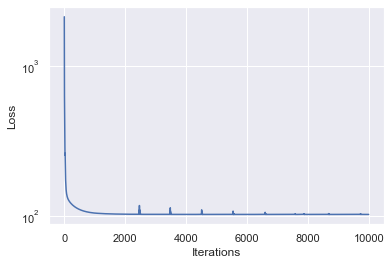

In [170]:
plt.plot(np.arange(NUM_EPOCHS),all_loses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')

In [171]:
pd.DataFrame(P.linear.weight.T.detach().cpu().numpy()).to_csv('../results/P.csv')

In [172]:
L2.shape

torch.Size([13181, 18])

In [173]:
P.eval()
M = torch.matmul(P.linear.weight,P.linear.weight.T)
torch.sum(torch.abs(M - I))

tensor(21.3419, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)

In [174]:
M

tensor([[ 3.7102e-01,  4.1502e-02, -1.3899e-01,  5.5126e-02,  7.9631e-02,
          5.6941e-02,  3.7155e-02,  4.1231e-03, -1.9496e-02,  6.2815e-03,
         -6.6205e-02, -7.0084e-03,  2.6990e-02,  2.4835e-02, -2.5277e-02,
         -9.0723e-03, -9.2862e-03,  6.9658e-02],
        [ 4.1502e-02,  6.0413e-01, -1.3024e-02, -7.7173e-02, -9.1543e-02,
         -1.0430e-01, -1.6697e-02, -2.5637e-02, -3.5100e-02, -1.8000e-03,
         -2.2739e-03, -1.1233e-02,  8.5377e-03, -2.9696e-02,  2.6107e-02,
          2.6842e-02, -4.8457e-03, -3.4939e-02],
        [-1.3899e-01, -1.3024e-02,  3.7142e-01, -7.3019e-03, -1.2622e-01,
          6.8878e-02,  6.2754e-03,  4.9292e-03,  1.4212e-02, -1.6448e-02,
          7.2051e-02, -5.2400e-03, -4.5171e-03,  1.0159e-04,  6.0433e-03,
         -8.4243e-03,  3.5547e-03, -3.7759e-02],
        [ 5.5126e-02, -7.7173e-02, -7.3019e-03,  1.0936e-01,  8.5173e-02,
          4.9549e-02,  1.5994e-02,  9.5968e-04,  9.5440e-03, -1.4339e-02,
          2.6215e-02,  1.0067e-02, -4.3

In [175]:
torch.diag(M)

tensor([0.3710, 0.6041, 0.3714, 0.1094, 0.1551, 0.1375, 0.0505, 0.0164, 0.0309,
        0.0276, 0.1007, 0.0313, 0.0154, 0.0397, 0.0580, 0.0174, 0.0155, 0.1142],
       device='cuda:0', dtype=torch.float64, grad_fn=<DiagBackward0>)